In [22]:
import torch
import urllib
from PIL import Image
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision.models import resnet50, squeezenet1_1

In [61]:
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [74]:
torch.set_grad_enabled(False)

In [2]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_0', pretrained=True)
model.eval()

Using cache found in /home/sunshine/.cache/torch/hub/pytorch_vision_v0.6.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [3]:
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")

try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [4]:
input_image = Image.open(filename)


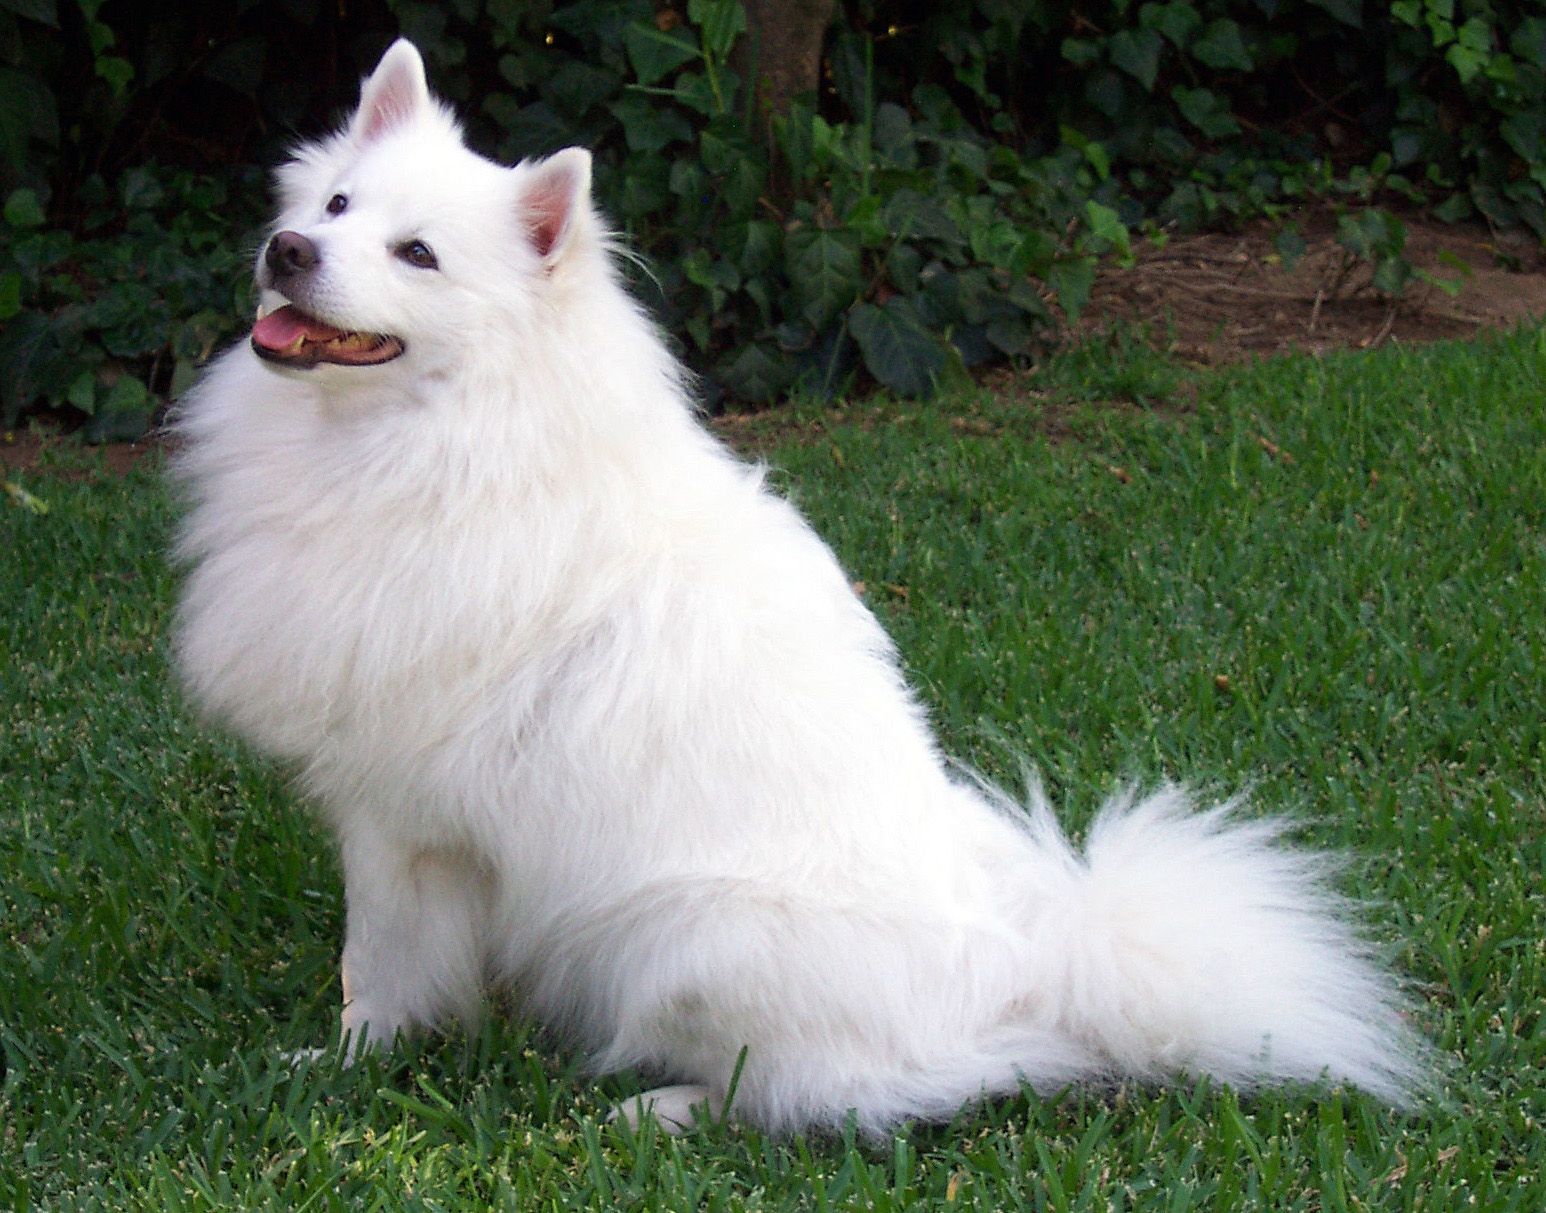

In [5]:
input_image

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.483, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    
with torch.no_grad():
    output = model(input_batch)

# print(output[0])

output_tensor = (torch.nn.functional.softmax(output[0], dim=0))

In [10]:
len(output_tensor)

1000

In [11]:
output_tensor.min()

tensor(5.0700e-16)

In [20]:
(output_tensor.max().data)

tensor(0.9039)

In [15]:
type(output_tensor)

torch.Tensor

In [9]:
output_tensor[500:560]

tensor([2.0729e-14, 1.9949e-10, 7.2010e-12, 7.1363e-14, 1.7973e-13, 7.0274e-14,
        1.5274e-14, 2.5089e-15, 1.0006e-09, 1.0136e-14, 8.9804e-16, 1.6068e-13,
        1.2220e-15, 3.0954e-13, 8.5692e-14, 6.1191e-11, 1.8913e-11, 3.7359e-15,
        7.6298e-14, 3.6036e-11, 1.2279e-11, 1.7311e-13, 6.2765e-12, 8.4972e-12,
        4.2945e-13, 1.2898e-12, 1.0878e-13, 2.8083e-13, 1.1896e-14, 2.9645e-11,
        4.7876e-14, 5.7840e-14, 1.4019e-13, 2.3822e-14, 4.5971e-09, 8.9212e-15,
        1.0162e-15, 1.3309e-08, 2.6088e-14, 1.8716e-07, 6.9155e-16, 7.7608e-14,
        3.5605e-14, 1.0392e-12, 1.0367e-13, 9.4117e-15, 1.2659e-13, 2.1207e-15,
        2.5874e-14, 1.0264e-13, 2.3916e-15, 1.5477e-12, 7.4955e-09, 7.7580e-13,
        1.6265e-12, 5.0764e-12, 3.0446e-15, 2.3276e-13, 9.0040e-13, 6.7769e-14])

In [26]:
import numpy as np

In [27]:
n_array = output_tensor.numpy()

In [32]:
output_tensor[65]

tensor(7.3286e-15)

In [30]:
n_array[70]

1.2789478e-15

# SqueezeNet + DETR

In [75]:
class DETR(nn.Module):
    
    def __init__(self, num_classes, hidden_dim=256, nheads=8, num_encoder_layers=6,
                num_decoder_layers=6):
        
        super().__init__()
        # get the list of squeezenet conv layers minus the last two i.e. avgpool & FC w/ classes
        # self.backbone = nn.Sequential(*list(squeezenet1_1(pretrained=True).children())[:-2])
        self.backbone = resnet50()
        del self.backbone.fc
        # in channels, out channels, kernel size, 2048 is from the last layer of SqueezeNett
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        # no. of heads in multiheadattention model
        # sub-encoder-layers in the encoder
        # sub-decoder-layers in the decoder
        self.transformer = nn.Transformer(hidden_dim, nheads,
                                          num_encoder_layers, num_decoder_layers) 
        # two linear layers 1 for class and 1 for the box
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)   # num_classes + no class so 1 for that
        self.linear_bbox = nn.Linear(hidden_dim,4)
        
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        
    def forward(self, inputs):
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        
        # Construct Positional Encodings
        # H is the number of rows
        # W is the number of channels of the output tensor
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}
    

In [76]:
detr = DETR(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
            map_location='cpu',check_hash = True)

In [77]:
torch.set_grad_enabled(False)

In [93]:
detr.load_state_dict(state_dict)
detr.eval();

In [69]:
# detr.eval()

In [101]:
# COCO classes
classes = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [95]:
# standard PyTorch mean-std input image normalization

transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [96]:
def detect(im, model, transform):
    # normalize the image
    img = transform(im).unsqueeze(0)
    # propagate through the model
    outputs = model(img)
    
    # keep only the predictions with confidence > 0.7 
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled


In [97]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
scores, boxes = detect(im, detr, transform)

In [98]:
scores

tensor([[9.3258e-12, 3.9835e-05, 1.2076e-10, 6.0267e-09, 3.6825e-09, 3.3015e-08,
         2.4853e-12, 2.4963e-09, 1.1988e-08, 1.2165e-11, 3.2585e-09, 2.1805e-08,
         7.7568e-12, 3.2640e-11, 2.1321e-08, 5.8303e-08, 2.6795e-05, 9.9767e-01,
         2.4542e-04, 8.3998e-10, 1.7251e-07, 2.7358e-07, 5.7316e-07, 5.5907e-06,
         2.6841e-05, 1.0291e-08, 1.1717e-11, 3.0885e-07, 1.9668e-11, 8.1391e-12,
         1.0973e-11, 1.7848e-07, 1.0780e-08, 6.1135e-07, 5.0391e-11, 1.3005e-09,
         1.0852e-07, 1.9537e-10, 8.6607e-11, 4.8292e-10, 3.8045e-10, 2.3101e-08,
         1.4360e-10, 5.9996e-12, 2.1270e-05, 8.3089e-12, 5.8261e-11, 2.1842e-07,
         1.7976e-08, 2.9958e-08, 1.3691e-08, 6.5169e-08, 2.0744e-10, 4.4708e-09,
         4.6316e-08, 5.2503e-09, 6.4615e-11, 4.8704e-07, 3.4992e-07, 3.8520e-10,
         1.7668e-09, 2.2983e-10, 3.3905e-08, 1.2054e-05, 6.8885e-09, 5.9989e-07,
         1.4283e-11, 3.9168e-08, 1.1338e-11, 9.3310e-12, 3.2707e-07, 1.1324e-11,
         7.1242e-08, 2.8498e

In [99]:
boxes

tensor([[1.4237e+01, 5.2648e+01, 3.0968e+02, 4.7448e+02],
        [4.0579e+01, 7.2045e+01, 1.7505e+02, 1.2057e+02],
        [3.4342e+02, 2.1900e+01, 6.3954e+02, 3.7115e+02],
        [4.2231e-01, 1.1729e+00, 6.4028e+02, 4.7372e+02],
        [3.3136e+02, 7.4511e+01, 3.6977e+02, 1.9231e+02]])

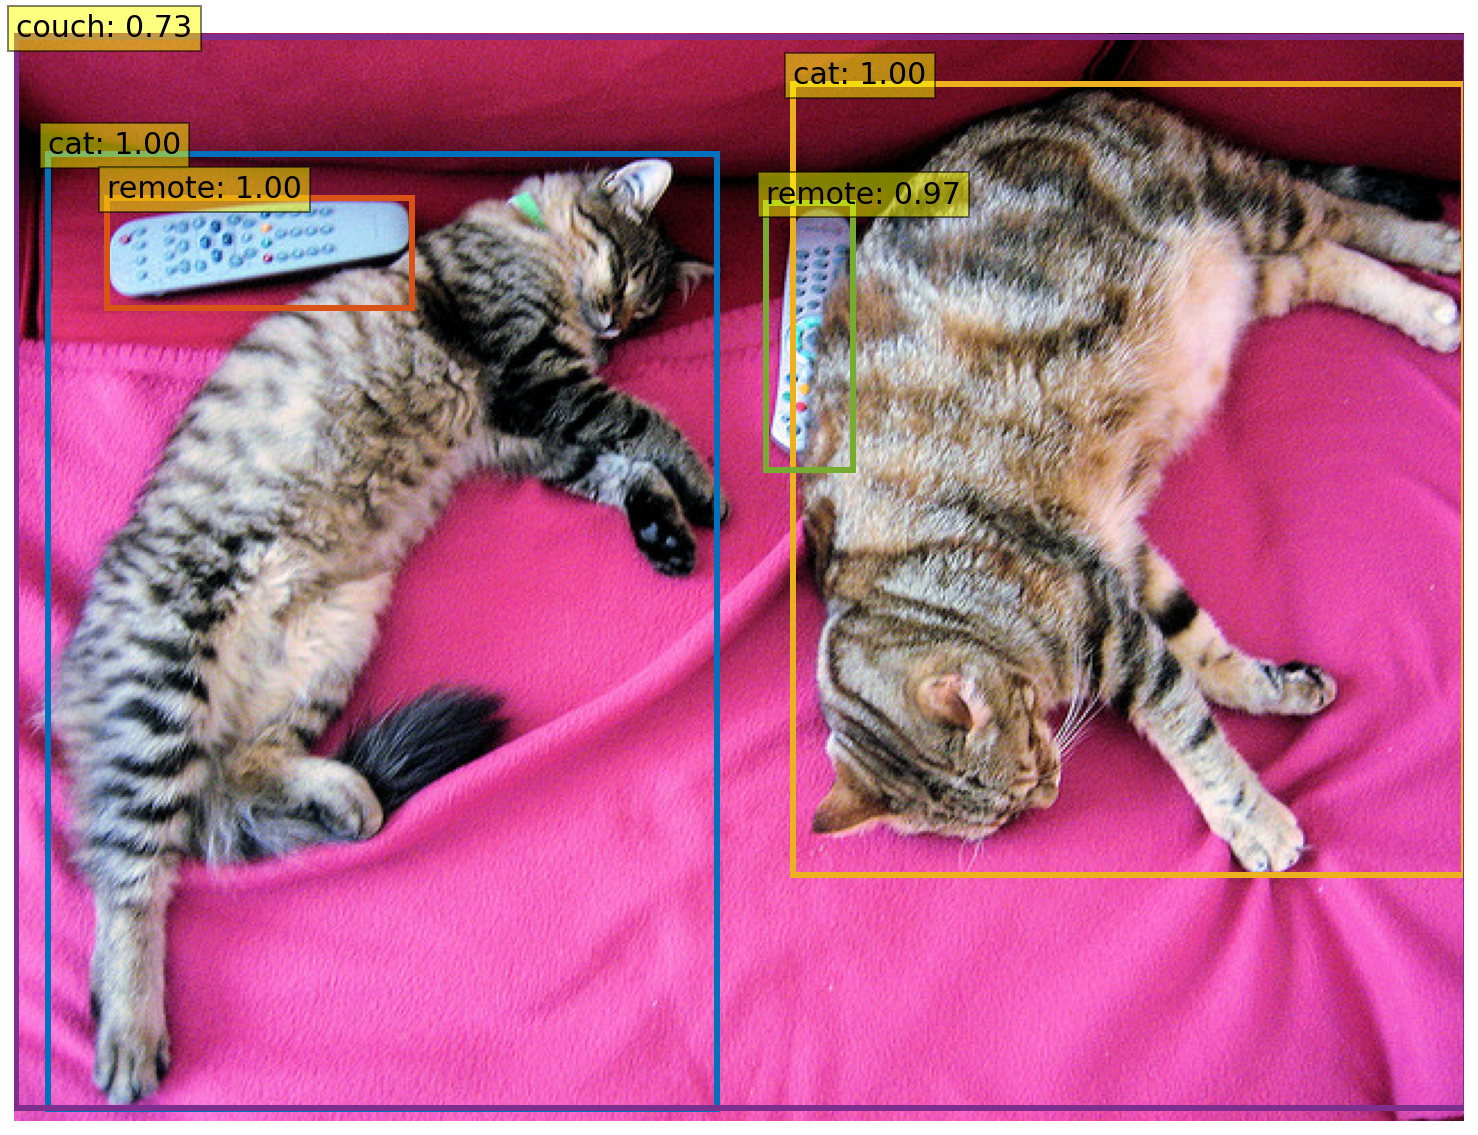

In [103]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin),xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        
        c1 = p.argmax()
        text = f'{classes[c1]}: {p[c1]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox = dict(facecolor ='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)

In [14]:
transformer_model = DETR(10, 3, 1, 2, 2)

In [15]:
transformer_model.backbone

Sequential()

In [16]:
transformer_model.conv

Conv2d(2048, 3, kernel_size=(1, 1), stride=(1, 1))

In [17]:
nn.Sequential(*list(squeezenet1_1(pretrained=True).children())[:-2])

Sequential()

In [18]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /home/sunshine/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/sunshine/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100.0%
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /home/sunshine/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100.0%


In [23]:
model = torchvision.models.squeezenet1_1(pretrained=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/sunshine/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth
100.0%


In [28]:
model=DETR(num_classes=91, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)


In [29]:
model.eval()

DETR(
  (backbone): Sequential()
  (conv): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          

# Pretrained

In [31]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in /home/sunshine/.cache/torch/hub/facebookresearch_detr_master


In [32]:
model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Drop